In [1]:
import os
import datetime

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from fbprophet import Prophet
from oanda_bot import Bot

ModuleNotFoundError: No module named 'oanda_bot'

In [2]:
token = os.environ['oanda_access_token']
account = os.environ['oanda_account_id']

In [6]:
def gen_band_flg(df):
    if df['y'] < df['yhat_lower']:
        return -1
    elif df['y'] > df['yhat_upper']:
        return 1
    else:
        return 0

In [5]:
# df = Bot(
#     account_id=account,
#     access_token=token,
#     environment='live',
#     instrument='USD_JPY',
#     granularity='M1', # 15 second candlestick
# )._candles(from_date="2021-1-1", to_date="2021-2-4")

# df.tail()

In [7]:
# df.to_csv('USD_JPY_M1_20210101_20210204.csv')

In [8]:
df_minute = pd.read_csv('USD_JPY_M1_20210101_20210204.csv')

In [9]:
df_minute_prophet = df_minute[['T', 'C']].copy()
df_minute_prophet.columns = ['ds', 'y']
df_minute_prophet['ds'] = pd.to_datetime(df_minute_prophet['ds'].apply(lambda x:x[:-6]))

In [10]:

df_eval_list = []

time_scale = 120
eval_window = time_scale * 96
train_duration = time_scale * 24 * 5 * 16

for s in tqdm(range(eval_window, -time_scale, -time_scale)):

    test_num = time_scale
    shift = 1 + s
    
    df_train = df_minute_prophet[:-shift][-train_duration:-test_num].copy()
    df_test = df_minute_prophet[:-shift][-test_num:].copy()

    m = Prophet(yearly_seasonality=False,
                weekly_seasonality=False,
                seasonality_mode='multiplicative')
    m.fit(df_train)

    future = m.make_future_dataframe(periods=test_num, freq='T' )
    forecast = m.predict(future)
    
    forecast_test = forecast[-test_num:][['ds', 'yhat_lower', 'yhat_upper', 'yhat']]
    df_eval_temp = pd.merge(forecast_test, df_test, on='ds')
    df_eval_temp['band_flg'] = df_eval_temp.apply(gen_band_flg, axis=1)
    df_eval_list.append(df_eval_temp)

100%|██████████| 97/97 [1:03:30<00:00, 39.28s/it]


In [11]:
df_eval = pd.concat(df_eval_list)

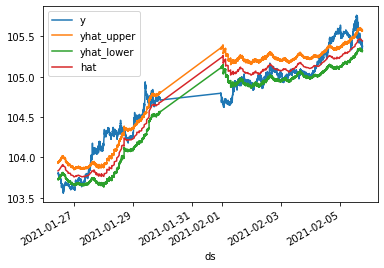

In [12]:
df_eval.set_index('ds')['y'].plot(label='y')
df_eval.set_index('ds')['yhat_upper'].plot(label='yhat_upper')
df_eval.set_index('ds')['yhat_lower'].plot(label='yhat_lower')
df_eval.set_index('ds')['yhat'].plot(label='hat')

plt.legend()
plt.show()

In [13]:
df_eval

,ds,yhat_lower,yhat_upper,yhat,y,band_flg
0,2021-01-26 10:54:00,103.731980,103.938634,103.833416,103.803,0
1,2021-01-26 10:56:00,103.722096,103.932625,103.833750,103.808,0
2,2021-01-26 10:57:00,103.730412,103.945817,103.833920,103.806,0
3,2021-01-26 10:58:00,103.738997,103.942004,103.834092,103.802,0
4,2021-01-26 10:59:00,103.730765,103.925698,103.834266,103.802,0
...,...,...,...,...,...,...
115,2021-02-05 18:00:00,105.315357,105.583120,105.443137,105.376,0
116,2021-02-05 18:01:00,105.313202,105.568490,105.442929,105.383,0
117,2021-02-05 18:02:00,105.322521,105.572618,105.442722,105.382,0
118,2021-02-05 18:03:00,105.324904,105.582312,105.442518,105.372,0
